In [72]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [73]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

## Carevue fluid outliers -- high amounts.
We are including OR and PACU fluids in our fluid balance calculations.  These do lead to some outliers.  with  up to 33L charted.  see table below. 


In [51]:
# carevue Operating room charted fluids codes.  
sql = """select * 
from mimiciii.inputevents_cv
where itemid in ('30101', '30102') 
and amount is not null
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,...,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,937761,7413,134105.0,219750.0,2172-11-04 23:00:00,30101,33000.0,ml,None,None,...,3045093,3045093,None,NaN,NaN,ml,Intravenous Push,None,None,None
1,936251,11353,108739.0,286981.0,2113-05-30 13:00:00,30101,30000.0,ml,None,None,...,5785664,5785664,None,NaN,NaN,ml,Intravenous Push,None,None,None
2,904217,18463,128430.0,253611.0,2173-11-06 00:15:00,30101,22000.0,ml,None,None,...,9810761,9810761,None,NaN,NaN,ml,Intravenous Push,None,None,None
3,937637,19095,131302.0,210780.0,2143-11-12 18:00:00,30102,19836.0,ml,None,None,...,4010437,4010437,None,NaN,NaN,ml,Intravenous Push,None,None,None
4,946177,20854,120046.0,288220.0,2157-04-29 20:00:00,30102,19375.0,ml,None,None,...,10468351,10468351,None,1.0,NaN,ml,Intravenous Push,None,None,None


(array([  1.44160000e+04,   3.88900000e+03,   1.87000000e+03,
          7.38000000e+02,   2.77000000e+02,   7.90000000e+01,
          9.00000000e+01,   3.80000000e+01,   1.90000000e+01,
          1.60000000e+01,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([     0.,   1650.,   3300.,   4950.,   6600.,   8250.,   9900.,
         11550.,  13200.,  14850.,  16500.,  18150.,  19800.,  21450.,
         23100.,  24750.,  26400.,  28050.,  29700.,  31350.,  33000.]),
 <a list of 20 Patch objects>)

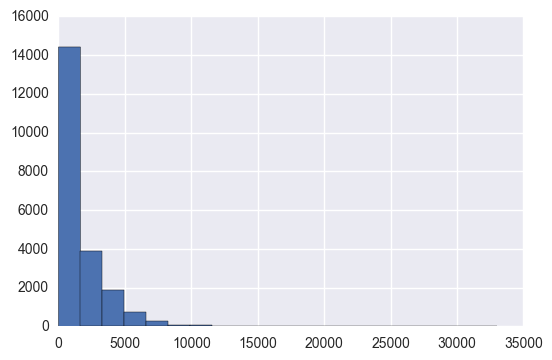

In [52]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)

In [53]:
output_notebook()
p = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue OR fluid amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p)

Loading BokehJS ...

In [54]:
# top Carevision input amounts:
sql = """
select * 
from fluid_cv_itemtotal
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head(100)

,icustay_id,day_since_admission,itemid,label,amount
0,219750,0.0,30101,OR Crystalloid,33000.0
1,245712,0.0,30030,Sodium Bicarbonate,30300.0
2,202865,48.0,30168,Normal Saline_GU,30000.0
3,286981,0.0,30101,OR Crystalloid,30000.0
4,253611,0.0,30101,OR Crystalloid,22000.0
5,210780,0.0,30102,OR Colloid,19836.0
6,288220,0.0,30102,OR Colloid,19375.0
7,223601,0.0,30101,OR Crystalloid,19000.0
8,245712,0.0,30030,Sodium Bicarbonate,18937.5
9,221955,0.0,30101,OR Crystalloid,18670.0


In [55]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p2 = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p2)

Loading BokehJS ...

## OR and PACU fluids do not end up in final extract from Metavision because they are listed as preadmission

In [56]:
## OR, PACU fluid from Metavision. empty results, so OR fluids not contributing to high fluid volumes.

sql = """SELECT row_id, subject_id, hadm_id, icustay_id, starttime, endtime, 
       itemid, amount, amountuom, rate, rateuom, storetime, patientweight, totalamount, totalamountuom, 
       isopenbag, continueinnextdept, cancelreason, statusdescription, 
       comments_editedby, comments_canceledby, comments_date,originalamount, 
       originalrate
  FROM mimiciii.inputevents_mv
  where itemid in ('226364', '226375', '226365', '226367')
  and amount > 0  -- amount can be negative, often for REWRITTEN orders.  
		and cancelreason = 0 -- some orders are cancelled
		and statusdescription != 'Rewritten'  -- not sure if this should be a filter.
		and ordercategoryname not like '%Pre Admission%' -- Pre Admission fluid can be very high and cover uncertain amount of time.  
		and icustay_id is not null
  order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate


## Metavision, top amounts of fluid 
top fluid up to 30L, come from LR PRBC, etc.  some of these are not yet in updated fluid extractions.  

In [57]:
sql = """SELECT f.row_id, f.subject_id, f.icustay_id, f.hadm_id, f.itemid, d.label, f.rate, f.amount, 
       starttime, endtime
  FROM mimiciii.fluid_mv_itemtotal as f
  join d_items as d
  on f.itemid = d.itemid
order by amount desc"""
df = pd.read_sql_query(sql, conn)


In [58]:
# top metavision input amounts
df.head(100)

,row_id,subject_id,icustay_id,hadm_id,itemid,label,rate,amount,starttime,endtime
0,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-10 00:00:00,2153-10-11 00:00:00
1,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-06 00:00:00,2153-10-07 00:00:00
2,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-04 23:35:00,2153-10-05 00:00:00
3,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-07 00:00:00,2153-10-08 00:00:00
4,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-08 00:00:00,2153-10-09 00:00:00
5,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-11 00:00:00,2153-10-11 05:25:00
6,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-09 00:00:00,2153-10-10 00:00:00
7,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-05 00:00:00,2153-10-06 00:00:00
8,711219,64590,253402,160850,225168,Packed Red Blood Cells,14250.000000,14250.000000,2123-04-06 03:27:00,2123-04-06 04:27:00
9,711213,64590,253402,160850,220970,Fresh Frozen Plasma,13800.000000,13800.000000,2123-04-06 03:31:00,2123-04-06 04:31:00


In [60]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p1 = figure(
   tools="pan,box_zoom,reset,save",
   title="Metavision fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p1)

Loading BokehJS ...

## Distribution of Output fluid amounts.  What is contributing to high fluid amounts. 
high output charting are from OR, PACU EBL

In [67]:
sql = """SELECT f.* , d.label
  FROM mimiciii.output_itemtotal as f
  join d_items as d
  on f.itemid = d.itemid
order by amount desc"""
df = pd.read_sql_query(sql, conn)
df.head()

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,211323,2186-02-26 20:34:07,2186-03-02 17:09:00,3 days 20:34:53,226626,50500.0,3.0,OR EBL
1,247086,2180-08-23 03:30:27,2180-08-23 12:41:00,0 days 09:10:33,226626,50000.0,0.0,OR EBL
2,234698,2122-04-29 20:33:01,2122-04-29 23:45:00,0 days 03:11:59,226626,50000.0,0.0,OR EBL
3,245211,2113-03-29 16:16:11,2113-03-30 13:00:00,0 days 20:43:49,226559,47050.0,0.0,Foley
4,272472,2122-01-02 11:18:40,2122-01-11 21:16:00,9 days 09:57:20,226626,30000.0,9.0,OR EBL


In [70]:
# top output amounts: 
df.head(100)

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,211323,2186-02-26 20:34:07,2186-03-02 17:09:00,3 days 20:34:53,226626,50500.0,3.0,OR EBL
1,247086,2180-08-23 03:30:27,2180-08-23 12:41:00,0 days 09:10:33,226626,50000.0,0.0,OR EBL
2,234698,2122-04-29 20:33:01,2122-04-29 23:45:00,0 days 03:11:59,226626,50000.0,0.0,OR EBL
3,245211,2113-03-29 16:16:11,2113-03-30 13:00:00,0 days 20:43:49,226559,47050.0,0.0,Foley
4,272472,2122-01-02 11:18:40,2122-01-11 21:16:00,9 days 09:57:20,226626,30000.0,9.0,OR EBL
5,266780,2185-02-21 19:38:00,2185-02-21 22:00:00,0 days 02:22:00,40064,30000.0,0.0,OR Out EBL
6,279359,2152-01-13 00:18:16,2152-01-15 22:51:00,2 days 22:32:44,226626,30000.0,2.0,OR EBL
7,228565,2148-12-07 12:30:16,2148-12-10 20:45:00,3 days 08:14:44,226629,29000.0,3.0,PACU EBL
8,221684,2119-10-30 15:42:34,2119-11-11 06:00:00,11 days 14:17:26,227489,28000.0,11.0,GU Irrigant/Urine Volume Out
9,233025,2178-12-14 10:45:00,2178-12-15 08:00:00,0 days 21:15:00,40584,28000.0,0.0,PD out


In [69]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p2 = figure(
   tools="pan,box_zoom,reset,save",
   title="Output fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p2)

Loading BokehJS ...

## are there any days without output measured?? --> yes. but only for minority of cases, and mostly not during first 3 days of ICU admission.  

In [76]:
sql = """with cte as 
(SELECT *, row_number() over (partition by icustay_id order by day_since_admission) as rn 
  FROM mimiciii.output_dailytotal)


, diff as (select a.*, b.day_since_admission - a.day_since_admission as d
  from cte a
  left join cte b
    on a.icustay_id = b. icustay_id
    and a.rn = b.rn-1)

select * from diff
where d is not null and d > 1
order by d desc
"""
df = pd.read_sql_query(sql, conn)
df

,icustay_id,day_since_admission,dailytotal_ml,rn,d
0,253919,12.0,0.00,13,96.0
1,223304,28.0,0.00,21,92.0
2,246145,29.0,0.00,23,91.0
3,235684,47.0,0.00,41,91.0
4,261571,29.0,0.00,20,90.0
5,229485,25.0,0.00,24,84.0
6,232928,8.0,29.00,9,72.0
7,214819,8.0,17.00,9,72.0
8,233789,52.0,36.00,45,63.0
9,245519,14.0,0.00,15,62.0


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq\backend\cython\message.c:4018)
    PyErr_CheckSignals()
KeyboardInterrupt


(array([ 898.,  374.,  254.,  269.,  169.,  136.,  126.,  139.,   76.,
          79.,   81.,   49.,   36.,   44.,   40.,   29.,   24.,   19.,
          15.,   16.,    6.,    6.,    3.,    8.,    6.,    6.,    5.,
           7.,   12.,    2.,    4.,    3.,    5.,    3.,    3.,    1.,
           1.,    2.,    1.,    1.,    1.,    1.,    0.,    0.,    0.,
           1.,    0.,    1.,    0.,    1.]),
 array([   0.  ,    3.28,    6.56,    9.84,   13.12,   16.4 ,   19.68,
          22.96,   26.24,   29.52,   32.8 ,   36.08,   39.36,   42.64,
          45.92,   49.2 ,   52.48,   55.76,   59.04,   62.32,   65.6 ,
          68.88,   72.16,   75.44,   78.72,   82.  ,   85.28,   88.56,
          91.84,   95.12,   98.4 ,  101.68,  104.96,  108.24,  111.52,
         114.8 ,  118.08,  121.36,  124.64,  127.92,  131.2 ,  134.48,
         137.76,  141.04,  144.32,  147.6 ,  150.88,  154.16,  157.44,
         160.72,  164.  ]),
 <a list of 50 Patch objects>)

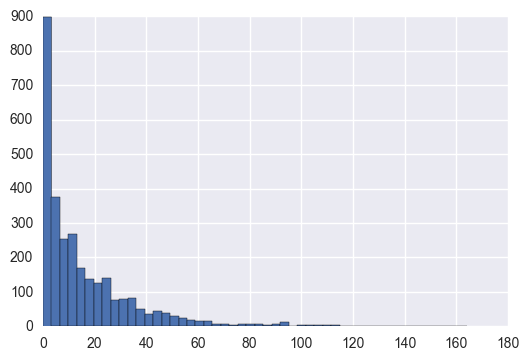

In [81]:
# day after which no output is charted.
plt.hist(df.day_since_admission, bins=50)

In [84]:
df[df.day_since_admission < 3].count()

icustay_id             719
day_since_admission    719
dailytotal_ml          719
rn                     719
d                      719
dtype: int64

In [85]:
df[df.day_since_admission > 3].count()

icustay_id             2065
day_since_admission    2065
dailytotal_ml          2065
rn                     2065
d                      2065
dtype: int64

In [86]:
719/2065

0.34818401937046006